In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import os

import petab
import pypesto
import pypesto.petab
from pypesto.optimize import minimize
from pypesto.engine import MultiProcessEngine
from pypesto.optimize.optimizer import FidesOptimizer
from pypesto.visualize import waterfall, parameters, profiles
from pypesto.visualize.model_fit import _get_simulation_rdatas
import pypesto.profile as profile
from pypesto.optimize import ScipyOptimizer
from pypesto.profile.options import ProfileOptions

Some plotting helper functions

In [2]:
def hex_to_rgba_gradient(color1, color2, n):
    '''
    Create a gradient in rgba between two hex colors
    '''
    # Convert to rgba
    c1 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color1))
    c2 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color2))

    return [[(c1[i]*(n-j-1) + c2[i]*j)/(n-1) for i in range(4)] for j in range(n)]

# find the index for cut off based on Chi square distribution CI 95%
def find_cut_off_index(result, ci = 0.95):
    '''
    Find the cut off index for the data based on the Chi square distribution
    '''

    # calculate the chi square distribution
    cut_off_value = scipy.stats.chi2.ppf(ci, 1)

    # find the index
    best_fval = result.optimize_result.list[0].fval

    for i in range(len(result.optimize_result.list)):
        if result.optimize_result.list[i].fval > best_fval + cut_off_value:
            break
    
    return i - 1

In [3]:
# Plot setting
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'Arial'

dpi = 100
wid = int(2560/dpi)
hei = int(1600/dpi)

red_color = '#f78884'
blue_color = '#06688c'

# Define the folder where you want to save the figures
folder_path = "../../figure/age_of_infection_model/"
# If the folder does not exist, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# import the petab problem and load the optimization result

In [4]:
# number of optimization runs
n_runs, max_iter = 5000, 5000
# set the random seed
np.random.seed(500)

In [5]:
# import the petab problem
petab_yaml = 'petab_files/age_of_infection_model.yaml'
petab.validate(petab_yaml)
petab_problem = petab.Problem.from_yaml(petab_yaml)

problem = pypesto.petab.PetabImporter(
        petab_problem,
        hierarchical=False,
        model_name=f"Age_of_Infection_Model",
    ).create_problem(force_compile=True, verbose=False)
problem.objective.amici_model.setAllStatesNonNegative()

# some model properties
print("Model parameters:", list(problem.objective.amici_model.getParameterIds()), "\n")
print("Model const parameters:", list(problem.objective.amici_model.getFixedParameterIds()), "\n")
print("Model outputs:   ", list(problem.objective.amici_model.getObservableIds()), "\n")
print("Model states:    ", list(problem.objective.amici_model.getStateIds()), "\n")

Compiling amici model to folder /Users/yuhongliu/Documents/OV/model/age_of_infection_model/amici_models/0.27.0/Age_of_Infection_Model.


Model parameters: ['rho', 'kappa', 'psi', 'phi', 'alpha', 'beta', 'delta', 'sigma_a', 'sigma_b'] 

Model const parameters: ['u_2'] 

Model outputs:    ['tumor_num'] 

Model states:     ['U', 'I_1', 'I_2', 'I_3', 'I_4', 'I_5', 'V'] 



In [6]:
# load result history from file
result = pypesto.store.read_result('optimization_history/age_of_infection_model.hdf5')

# print result summary
print(result.summary())

Loading the profiling result failed. It is highly likely that no profiling result exists within optimization_history/age_of_infection_model.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within optimization_history/age_of_infection_model.hdf5.


## Optimization Result 

* number of starts: 5000 
* best value: 723.3574913135295, id=1266
* worst value: inf, id=998
* number of non-finite values: 890

* execution time summary:
	* Mean execution time: 1.315s
	* Maximum execution time: 43.035s,	id=1806
	* Minimum execution time: 0.034s,	id=162
* summary of optimizer messages:

  |   Count | Message                                                     |
  |--------:|:------------------------------------------------------------|
  |    4099 | Converged according to fval difference                      |
  |     890 | Encountered non-finite function inf value at initial point. |
  |      11 | Trust Region Radius too small to proceed                    |

* best value found (approximately) 2274 time(s)
* number of plateaus found: 26

A summary of the best run:

### Optimizer Result

* optimizer used: <FidesOptimizer  hessian_update=default verbose=False options={'maxiter': 5000}>
* message: Converged according to fval difference 
* numbe

In [7]:
parameters_from_result = dict(zip(problem.x_names, result.optimize_result.list[0]['x']))
# Scale all parameters and put them into a dictionary
scaled_parameters = {key: 10**value for key, value in parameters_from_result.items()}

# Print the scaled parameters
print("Scaled parameters:")
for key, value in scaled_parameters.items():
    print(f"{key}: {value}")

Scaled parameters:
rho: 1.3719998890173604
kappa: 1138.1028737412514
psi: 3.0451973420634607e-09
phi: 2.9021941106845426
beta: 1.0541567420359819
alpha: 2.9016154167675983
delta: 0.37236432467696445
sigma_a: 166.4831321759065
sigma_b: 0.35929982754367545


# Obtain data and visualize the fitting result

In [8]:
return_dict = problem.objective(result.optimize_result.list[0].x, return_dict=True)
rdatas = return_dict['rdatas']
edatas = problem.objective.edatas
x_axis = [edata.id for edata in edatas]
simulation = [rdata.y.reshape(5, -1)[:,0] for rdata in rdatas]
data = [np.array(edata.getObservedData()).reshape(5, -1) for edata in edatas]

In [9]:
# get the statistics for 95% CI
cut_off_index = find_cut_off_index(result)
# define as in petab_files_creation.ipynb to convert the data back to tumor volume
s = 3510.7678534742176

In [10]:
"""
visualize the temporal dynamics of the virus, uninfected and infected tumor cells using the fitted model from the result
from day 3 to day 7
get the simulation results for the optimized parameters
"""

amici_model = problem.objective.amici_model

L = 5
species_to_plot = ['U'] + ['I_1'] + [f'I_{L}'] + ['V']

# simulate from day 3 to day 12
stop_day = 4
timepoints = np.linspace(start=0, stop=stop_day, num=100)

simulation_rdatas = _get_simulation_rdatas(
    result=result,
    problem=problem,
    start_index = 0,
    simulation_timepoints=timepoints,
)

In [14]:
# calculate the 1-sigma for the simulation
sigma_a = scaled_parameters['sigma_a']
sigma_b = scaled_parameters['sigma_b']

sigma_pbs = np.sqrt(sigma_a**2 + (simulation_rdatas[0]['y'].reshape(1, -1)[0] * sigma_b)**2)
sigma_vvDD = np.sqrt(sigma_a**2 + (simulation_rdatas[1]['y'].reshape(1, -1)[0] * sigma_b)**2)

# Calculate mean and standard error for vvDD
vvDD_mean = (data[1]*s).mean(axis=1)
vvDD_se = (data[1]*s).std(axis=1)
# Calculate mean and standard error for PBS
pbs_mean = (data[0]*s).mean(axis=1)
pbs_se = (data[0]*s).std(axis=1)

/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_18835/3984454537.py:75: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=-0.1, hspace=0.1)  # Adjust space between subplots
/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_18835/3984454537.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


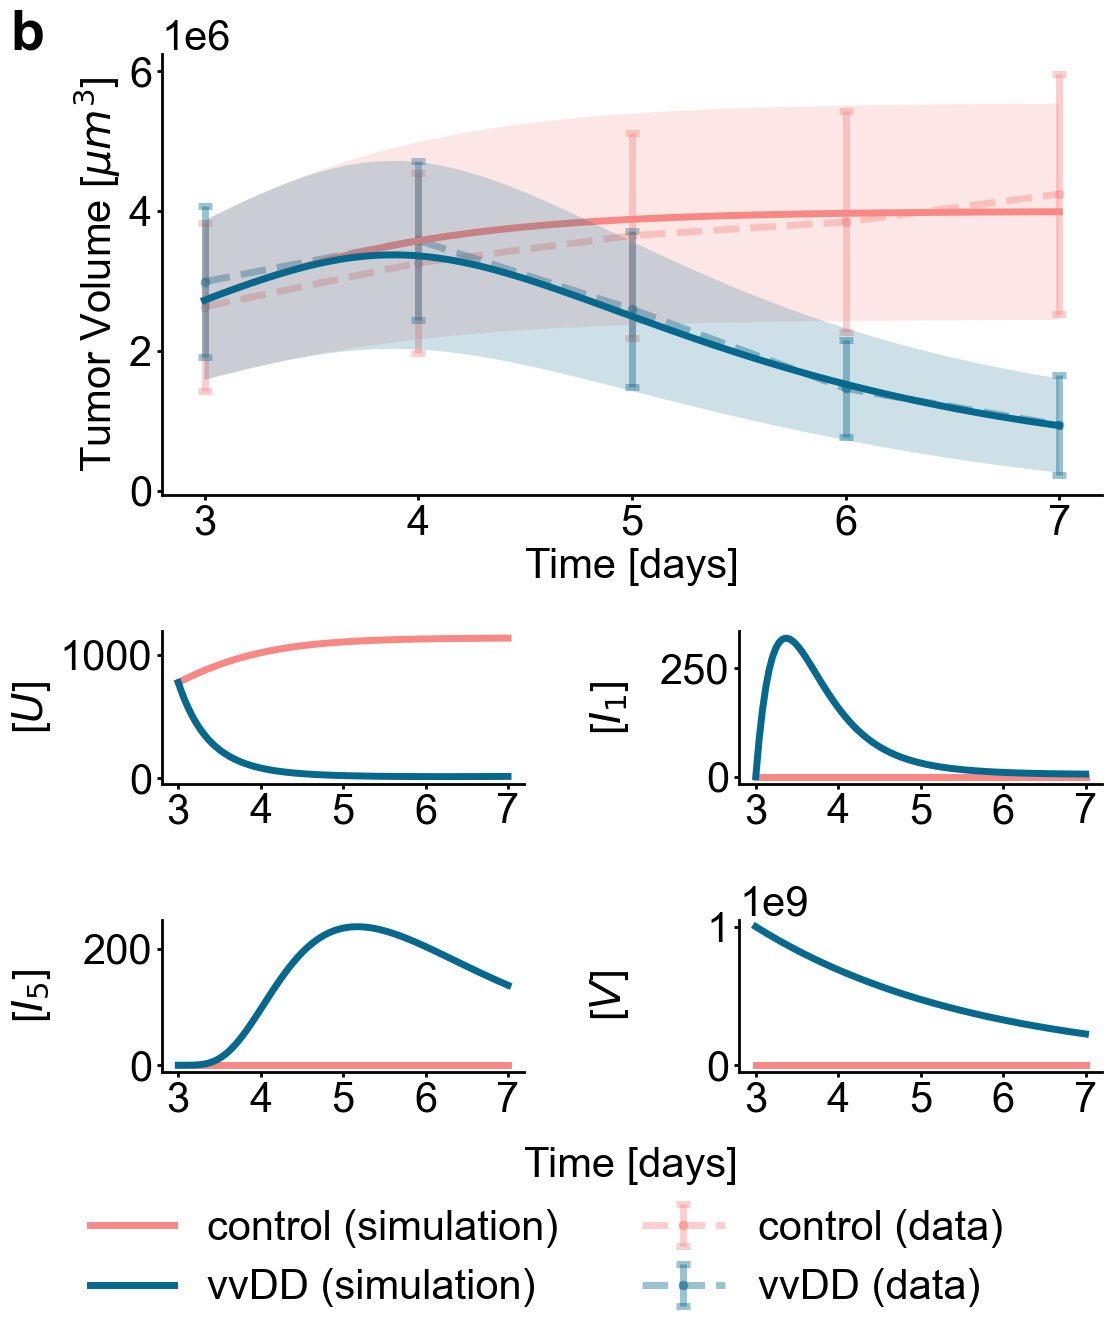

In [15]:
# Create a 3x2 subplot layout with shared x-axis for all subplots
"""
the first column is for the model vs data population plot
the second column is for the state trajectories plot
"""
fig = plt.figure(figsize=(12, 12), constrained_layout=True)

gs = fig.add_gridspec(4, 2)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[3, 1])

# Panel a: Model vs data (population)
ax1.errorbar(np.array([3, 4, 5, 6, 7]), pbs_mean, yerr=[pbs_se], fmt='o--', lw=5, color=red_color, alpha=0.4, ecolor=red_color, capsize=5, capthick=5, label='control (data)', zorder=1)
ax1.errorbar(np.array([3, 4, 5, 6, 7]), vvDD_mean, yerr=[vvDD_se], fmt='o--', lw=5, color=blue_color, alpha=0.4, ecolor=blue_color, capsize=5, capthick=5, label='vvDD (data)', zorder=2)
ax1.plot(timepoints + 3, simulation_rdatas[0]['y'].reshape(1, -1)[0] * s, linestyle='-', lw=5, color=red_color, alpha=1, label='control (simulation)', zorder=3)
ax1.plot(timepoints + 3, simulation_rdatas[1]['y'].reshape(1, -1)[0] * s, linestyle='-', lw=5, color=blue_color, alpha=1, label='vvDD (simulation)', zorder=4)
ax1.fill_between(timepoints + 3, simulation_rdatas[0]['y'].reshape(1, -1)[0] * s - s * sigma_pbs, simulation_rdatas[0]['y'].reshape(1, -1)[0] * s + s * sigma_pbs, color=red_color, alpha=0.2, edgecolor='none', zorder=3)
ax1.fill_between(timepoints + 3, simulation_rdatas[1]['y'].reshape(1, -1)[0] * s - s * sigma_vvDD, simulation_rdatas[1]['y'].reshape(1, -1)[0] * s + s * sigma_vvDD, color=blue_color, alpha=0.2, edgecolor='none', zorder=4)
ax1.set_xlabel('Time [days]')
ax1.set_ylabel(r'Tumor Volume [$\mu m^3$]')
# ax1.set_title('Model vs data (population)', pad=20, loc='center')
ax1.grid(False)
ax1.set_xticks([3, 4, 5, 6, 7])

ax1.yaxis.set_tick_params(labelleft=True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.tick_params(width=2)

# calculate the 1-sigma for the simulation
sigma_a = scaled_parameters['sigma_a']
sigma_b = scaled_parameters['sigma_b']

# Panel b: State trajectories
axs = [ax2, ax3, ax4, ax5]
for i, species in enumerate(species_to_plot):
    for c_, condition in enumerate(['ctrl', 'vvDD']):
        ax = axs[i]
        color = red_color if condition == 'ctrl' else blue_color
        ax.plot(timepoints + 3, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color=color, lw=5)
        ax.set_xticks(np.arange(3, stop_day + 4, 1))
        ax.set_xticklabels(np.arange(3, stop_day + 4, 1))
        if i == 0:
            # ax.set_title(f"{condition}", pad=20, loc='center')
            ax.set_ylabel(r'[$U$]', labelpad=20)
        elif i == 1:
            ax.set_ylabel(r'[$I_1$]', labelpad=20)
        elif i == 2:
            ax.set_ylabel(fr'[$I_{L}$]', labelpad=20)
        elif i == 3:
            ax.set_ylabel(r'[$V$]', labelpad=20)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.tick_params(width=2)

# Adjust the position of the y-axis labels
for ax in axs:
    ax.yaxis.set_label_coords(-0.3, 0.5)

fig.text(0.57, -0.01, 'Time [days]', ha='center', fontsize=30)

ax1.text(-0.125, 1.1, 'b', transform=ax1.transAxes, fontsize=40, fontweight='bold', va='top', ha='right')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.15))

plt.subplots_adjust(wspace=-0.1, hspace=0.1)  # Adjust space between subplots

plt.tight_layout()
# plt.savefig(folder_path + 'pop_and_states_slim.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Parameter estimation analysis

In [ ]:
result.problem.x_scales = ['log10'] * len(result.problem.x_names)

In [ ]:
panel_labels = ['a', 'b', 'c', 'd']

In [ ]:
plt.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(wid, hei))

gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

waterfall(result, ax=ax1)
ax1.set_ylabel('Objective value')

# Parameter plots in the second row
pypesto.visualize.parameters(result, ax=ax2, plot_inner_parameters=False, start_indices=cut_off_index, colors=hex_to_rgba_gradient('#A7C9F8', '#28518B', cut_off_index))
pypesto.visualize.parameters(result, ax=ax3, plot_inner_parameters=False, start_indices=300, colors=hex_to_rgba_gradient('#A7C9F8', '#28518B', 300))
pypesto.visualize.parameters(result, ax=ax4, plot_inner_parameters=False, start_indices=100, colors=hex_to_rgba_gradient('#A7C9F8', '#28518B', 100))

ax2.set_title('95% CI', fontsize=30)
ax3.set_title('Top 300', fontsize=30)
ax4.set_title('Top 100', fontsize=30)

# Set all the x-axis, x and y labels to have fontsize 30
for ax in [ax2, ax3, ax4]:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=45)
    ax.set_xlabel('Parameter Value', fontsize=30)
ax2.set_ylabel('Parameter', fontsize=30)

# Remove top and right lines and make lines and ticks thicker
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(width=2)
    # Add panel labels
    if i == 0:
        ax.text(-0.115, 1.3, panel_labels[i], transform=ax.transAxes, fontsize=40, fontweight='bold', va='top', ha='right')
    else:
        ax.text(-0.55, 1.3, panel_labels[i], transform=ax.transAxes, fontsize=40, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'waterfall_parameters_plot.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

# Profiling

In [ ]:
result = profile.parameter_profile(
    problem=problem,
    result=result,
    engine=MultiProcessEngine(),
    optimizer=ScipyOptimizer(),
    result_index=0,
    profile_options=ProfileOptions(whole_path=False),
)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()  # Flatten the 2D array to 1D for easier iteration
labels = ["$\\rho$", "$\\kappa$", "$\\psi$", "$\\phi$", "$\\beta$", "$\\alpha$", "$\\delta$", "$\\sigma_{a}$", "$\\sigma_{b}$"]

profiles(result, show_bounds=True, size=(12, 10), colors=[0,0,0,1], profile_list_ids=len(result.profile_result.list)-1, quality_colors=False, ax=ax)

for i, a in enumerate(ax):
    a.set_ylim([0, 1.1])
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_linewidth(2)
    a.spines['bottom'].set_linewidth(2)
    a.tick_params(width=2, labelsize=25)  # Set tick label size to 20
    for label in a.get_xticklabels():
        label.set_rotation(45)
    a.set_xlabel(rf'{labels[i]}', fontsize=40)  # Change x-axis label to math notation and increase font size
    a.set_ylabel('')  # Remove innate y-label
    if len(a.get_xticks()) == 12:
        a.set_xticks(a.get_xticks()[::3])
    if len(a.get_xticks()) == 9 or len(a.get_xticks()) == 8 or len(a.get_xticks()) == 7:
        a.set_xticks(a.get_xticks()[::2])
    if i == 0:
        a.set_xticklabels([f'${{{10**(tick):.2f}}}$' for tick in a.get_xticks()])
    else:
        a.set_xticklabels([f'$10^{{{int(tick)}}}$' for tick in a.get_xticks()])

# Add a common y-label
fig.text(0.03, 0.5, 'Likelihood Ratio', va='center', rotation='vertical', fontsize=30)
# Adjust the position of the y-axis labels
for a in ax:
    a.xaxis.set_label_coords(0.55, -0.5)

plt.subplots_adjust(wspace=0.5, hspace=1.1)
plt.savefig(os.path.join(folder_path, 'profile_plot_res.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

# AIC and residue plot

In [ ]:
# Calculate AIC
AIC = 2 * len(result.optimize_result.list[0]['x']) + 2 * result.optimize_result.list[0]['fval']

print(f"AIC: {AIC}")

In [ ]:
n_measurements = 100
n_parameters = len(result.optimize_result.list[0]['x'])

# Calculate AIC for the small dataset
AIC_small = AIC + (2. * n_parameters**2 + 2.*n_parameters)/(n_measurements - n_parameters - 1)

print(f"AICc: {AIC_small}")